In [ ]:
import os
import pandas as pd
import re
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid, softmax
from tensorflow.keras.optimizers import*
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dense, BatchNormalization

In [ ]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [ ]:
df = pd.read_csv("dataset_flop_final.csv", header = 0)
df

,game_id,stack,flop_position,nb_players_start,cards,pot_size_before_decision,nb_unfolded_players,money_to_add_to_call,hand_strength,hand_pos_potential,hand_neg_potential,last_raise__preflop_player,last_raise_flopplayer,flop,mise en cas de raise/bet,decision
0,808943744,27.00,1,9,9c Ac,9.50,3,0.00,0.551804,0.101659,0.148031,1,-1,4h 8s 2s,0.00,checks
1,808943744,27.00,1,9,9c Ac,12.70,2,3.20,0.551804,0.101659,0.148031,1,0,4h 8s 2s,12.00,raises
2,808939395,17.50,1,5,As Kd,8.50,3,2.00,0.736818,0.080969,0.123679,1,-1,3h 3c 7s,2.00,bets
3,808939395,15.50,1,5,As Kd,47.71,3,35.21,0.736818,0.080969,0.123679,1,2,3h 3c 7s,0.00,folds
4,808938724,17.70,0,4,Th Kh,6.90,3,2.00,0.534690,0.062459,0.213058,0,-1,6d Ad 5d,2.00,bets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,788424042,58.00,1,8,6h Th,4.00,2,2.53,0.897317,0.075439,0.085235,-1,-1,2c 4h Tc,2.53,bets
7010,788421342,53.00,1,7,Ad As,17.00,2,12.00,0.951434,0.064151,0.084354,1,-1,8c 9h Qc,12.00,bets
7011,788418947,13.25,0,6,Ac Kd,4.00,2,1.90,0.736818,0.079585,0.128340,0,-1,2d 8d 2h,1.90,bets
7012,788417975,11.96,1,6,Qd Qc,9.87,3,4.00,0.955134,0.080272,0.074927,1,-1,Td 3d 5h,4.00,bets


In [ ]:
df["top_card_player"] = 0
df["diff_between_cards_player"] = 0
df["diff_2_3_highest_board"] = 0
df["diff_1_2_highest_board"] = 0
df["top_card_board"]=0

df["color"] = 0
#df = df.drop(columns=['game_id', 'high_value', 'min_value', 'same_color'])
df['decision'] = df['decision'].replace({'checks': 'calls', 'bets': 'raises'})

df


,game_id,stack,flop_position,nb_players_start,cards,pot_size_before_decision,nb_unfolded_players,money_to_add_to_call,hand_strength,hand_pos_potential,...,last_raise_flopplayer,flop,mise en cas de raise/bet,decision,top_card_player,diff_between_cards_player,diff_2_3_highest_board,diff_1_2_highest_board,top_card_board,color
0,808943744,27.00,1,9,9c Ac,9.50,3,0.00,0.551804,0.101659,...,-1,4h 8s 2s,0.00,calls,0,0,0,0,0,0
1,808943744,27.00,1,9,9c Ac,12.70,2,3.20,0.551804,0.101659,...,0,4h 8s 2s,12.00,raises,0,0,0,0,0,0
2,808939395,17.50,1,5,As Kd,8.50,3,2.00,0.736818,0.080969,...,-1,3h 3c 7s,2.00,raises,0,0,0,0,0,0
3,808939395,15.50,1,5,As Kd,47.71,3,35.21,0.736818,0.080969,...,2,3h 3c 7s,0.00,folds,0,0,0,0,0,0
4,808938724,17.70,0,4,Th Kh,6.90,3,2.00,0.534690,0.062459,...,-1,6d Ad 5d,2.00,raises,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,788424042,58.00,1,8,6h Th,4.00,2,2.53,0.897317,0.075439,...,-1,2c 4h Tc,2.53,raises,0,0,0,0,0,0
7010,788421342,53.00,1,7,Ad As,17.00,2,12.00,0.951434,0.064151,...,-1,8c 9h Qc,12.00,raises,0,0,0,0,0,0
7011,788418947,13.25,0,6,Ac Kd,4.00,2,1.90,0.736818,0.079585,...,-1,2d 8d 2h,1.90,raises,0,0,0,0,0,0
7012,788417975,11.96,1,6,Qd Qc,9.87,3,4.00,0.955134,0.080272,...,-1,Td 3d 5h,4.00,raises,0,0,0,0,0,0


In [ ]:
cards = df["cards"]
deck = df["flop"]
d = deck[6784]
j = 0
def get_value(s):
  if s == 'A':
    return 14
  if s=='K':
    return 13
  if s== 'Q':
    return 12
  if s== 'J':
    return 11
  if s == '1':
    return 10
  return int(s)

values_deck = []

if d[0] == "1":
  values_deck.append(10)
  j += 1
else :
  values_deck.append(get_value(d[0]))

j += 1
values_deck.append(d[j])
j +=2
if d[j] == "1":
  values_deck.append(10)
  j += 1
else :
  values_deck.append(get_value(d[j]))

j += 1
values_deck.append(d[j])

j +=2
if d[j] == "1":
  values_deck.append(10)
  j += 1
else :
  values_deck.append(get_value(d[j]))

j += 1
values_deck.append(d[j])


values_deck

[11, 'h', 6, 's', 3, 'd']

In [ ]:
cards = df["cards"]
deck = df["flop"]
#cards

def get_value(s):
  if s == 'A':
    return 14
  if s=='K':
    return 13
  if s== 'Q':
    return 12
  if s== 'J':
    return 11
  if (s == '1') | (s=='T'):
    return 10
  return int(s)


for i in range(df.shape[0]):
  index = 0
  j = 0
  values = []
  values_deck = []
  c = df['cards'][i]
  d = df['flop'][i]
  if c[0] == "1":
    values.append(10)
    index+=1
  else :
    values.append(get_value(c[0]))

  index += 1
  values.append(c[index])
  index+=2
  if c[index] == "1":
    values.append(10)
    index+=1
  else :
    values.append(get_value(c[index]))

  index += 1
  values.append(c[index])


  if d[0] == "1":
    values_deck.append(10)
    j += 1
  else :
    values_deck.append(get_value(d[0]))

  j += 1
  values_deck.append(d[j])
  j +=2
  if d[j] == "1":
    values_deck.append(10)
    j += 1
  else :
    values_deck.append(get_value(d[j]))

  j += 1
  values_deck.append(d[j])

  j +=2
  if d[j] == "1":
    values_deck.append(10)
    j += 1
  else :
    values_deck.append(get_value(d[j]))

  j += 1
  values_deck.append(d[j])

  num  = [values_deck[0], values_deck[2], values_deck[4]]
  num_sorted = sorted(num, reverse=True)
  df["top_card_board"][i]=num_sorted[0]
  df["diff_1_2_highest_board"][i]=num_sorted[0]-num_sorted[1]
  df["top_card_player"][i] = max(values[0], values[2])
  df["diff_between_cards_player"][i] = abs(values[0] - values[2])
  df["diff_2_3_highest_board"][i] =  num_sorted[1] - num_sorted[2]




  if (values_deck[1] == values_deck[3]) & (values_deck[1] == values_deck[5]):
    df["color"][i] = 0
  elif ( (values_deck[1] == values_deck[3]) & (values_deck[1] != values_deck[5]) ) | ( (values_deck[1] == values_deck[5]) & (values_deck[1] != values_deck[2]) ) | ( (values_deck[3] == values_deck[5]) & (values_deck[1] != values_deck[3]) ):
    df["color"][i] = 1
  else :
    df["color"][i] = 2

  if df['decision'][i] == 'folds' :
    df['decision'][i] = 0
  elif df['decision'][i] == 'calls' :
    df['decision'][i] = 1
  elif df['decision'][i] == 'raises' :
    df['decision'][i] = 2
  if i == 0 :
    print(values_deck)


df


<ipython-input-7-37c2413c5a9c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["top_card_board"][i]=num_sorted[0]
<ipython-input-7-37c2413c5a9c>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_1_2_highest_board"][i]=num_sorted[0]-num_sorted[1]
<ipython-input-7-37c2413c5a9c>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["top_card_player"][i] = max(values[0], values[2])
<ipython-input-7-37c2413c5a9c>:78: SettingWit

[4, 'h', 8, 's', 2, 's']


Streaming output truncated to the last 5000 lines.
<ipython-input-7-37c2413c5a9c>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_1_2_highest_board"][i]=num_sorted[0]-num_sorted[1]
<ipython-input-7-37c2413c5a9c>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["top_card_player"][i] = max(values[0], values[2])
<ipython-input-7-37c2413c5a9c>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_between_cards_player"][

,game_id,stack,flop_position,nb_players_start,cards,pot_size_before_decision,nb_unfolded_players,money_to_add_to_call,hand_strength,hand_pos_potential,...,last_raise_flopplayer,flop,mise en cas de raise/bet,decision,top_card_player,diff_between_cards_player,diff_2_3_highest_board,diff_1_2_highest_board,top_card_board,color
0,808943744,27.00,1,9,9c Ac,9.50,3,0.00,0.551804,0.101659,...,-1,4h 8s 2s,0.00,1,14,5,2,4,8,1
1,808943744,27.00,1,9,9c Ac,12.70,2,3.20,0.551804,0.101659,...,0,4h 8s 2s,12.00,2,14,5,2,4,8,1
2,808939395,17.50,1,5,As Kd,8.50,3,2.00,0.736818,0.080969,...,-1,3h 3c 7s,2.00,2,14,1,0,4,7,2
3,808939395,15.50,1,5,As Kd,47.71,3,35.21,0.736818,0.080969,...,2,3h 3c 7s,0.00,0,14,1,0,4,7,2
4,808938724,17.70,0,4,Th Kh,6.90,3,2.00,0.534690,0.062459,...,-1,6d Ad 5d,2.00,2,13,3,1,8,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,788424042,58.00,1,8,6h Th,4.00,2,2.53,0.897317,0.075439,...,-1,2c 4h Tc,2.53,2,10,4,2,6,10,1
7010,788421342,53.00,1,7,Ad As,17.00,2,12.00,0.951434,0.064151,...,-1,8c 9h Qc,12.00,2,14,0,1,3,12,1
7011,788418947,13.25,0,6,Ac Kd,4.00,2,1.90,0.736818,0.079585,...,-1,2d 8d 2h,1.90,2,14,1,0,6,8,1
7012,788417975,11.96,1,6,Qd Qc,9.87,3,4.00,0.955134,0.080272,...,-1,Td 3d 5h,4.00,2,12,0,2,5,10,1


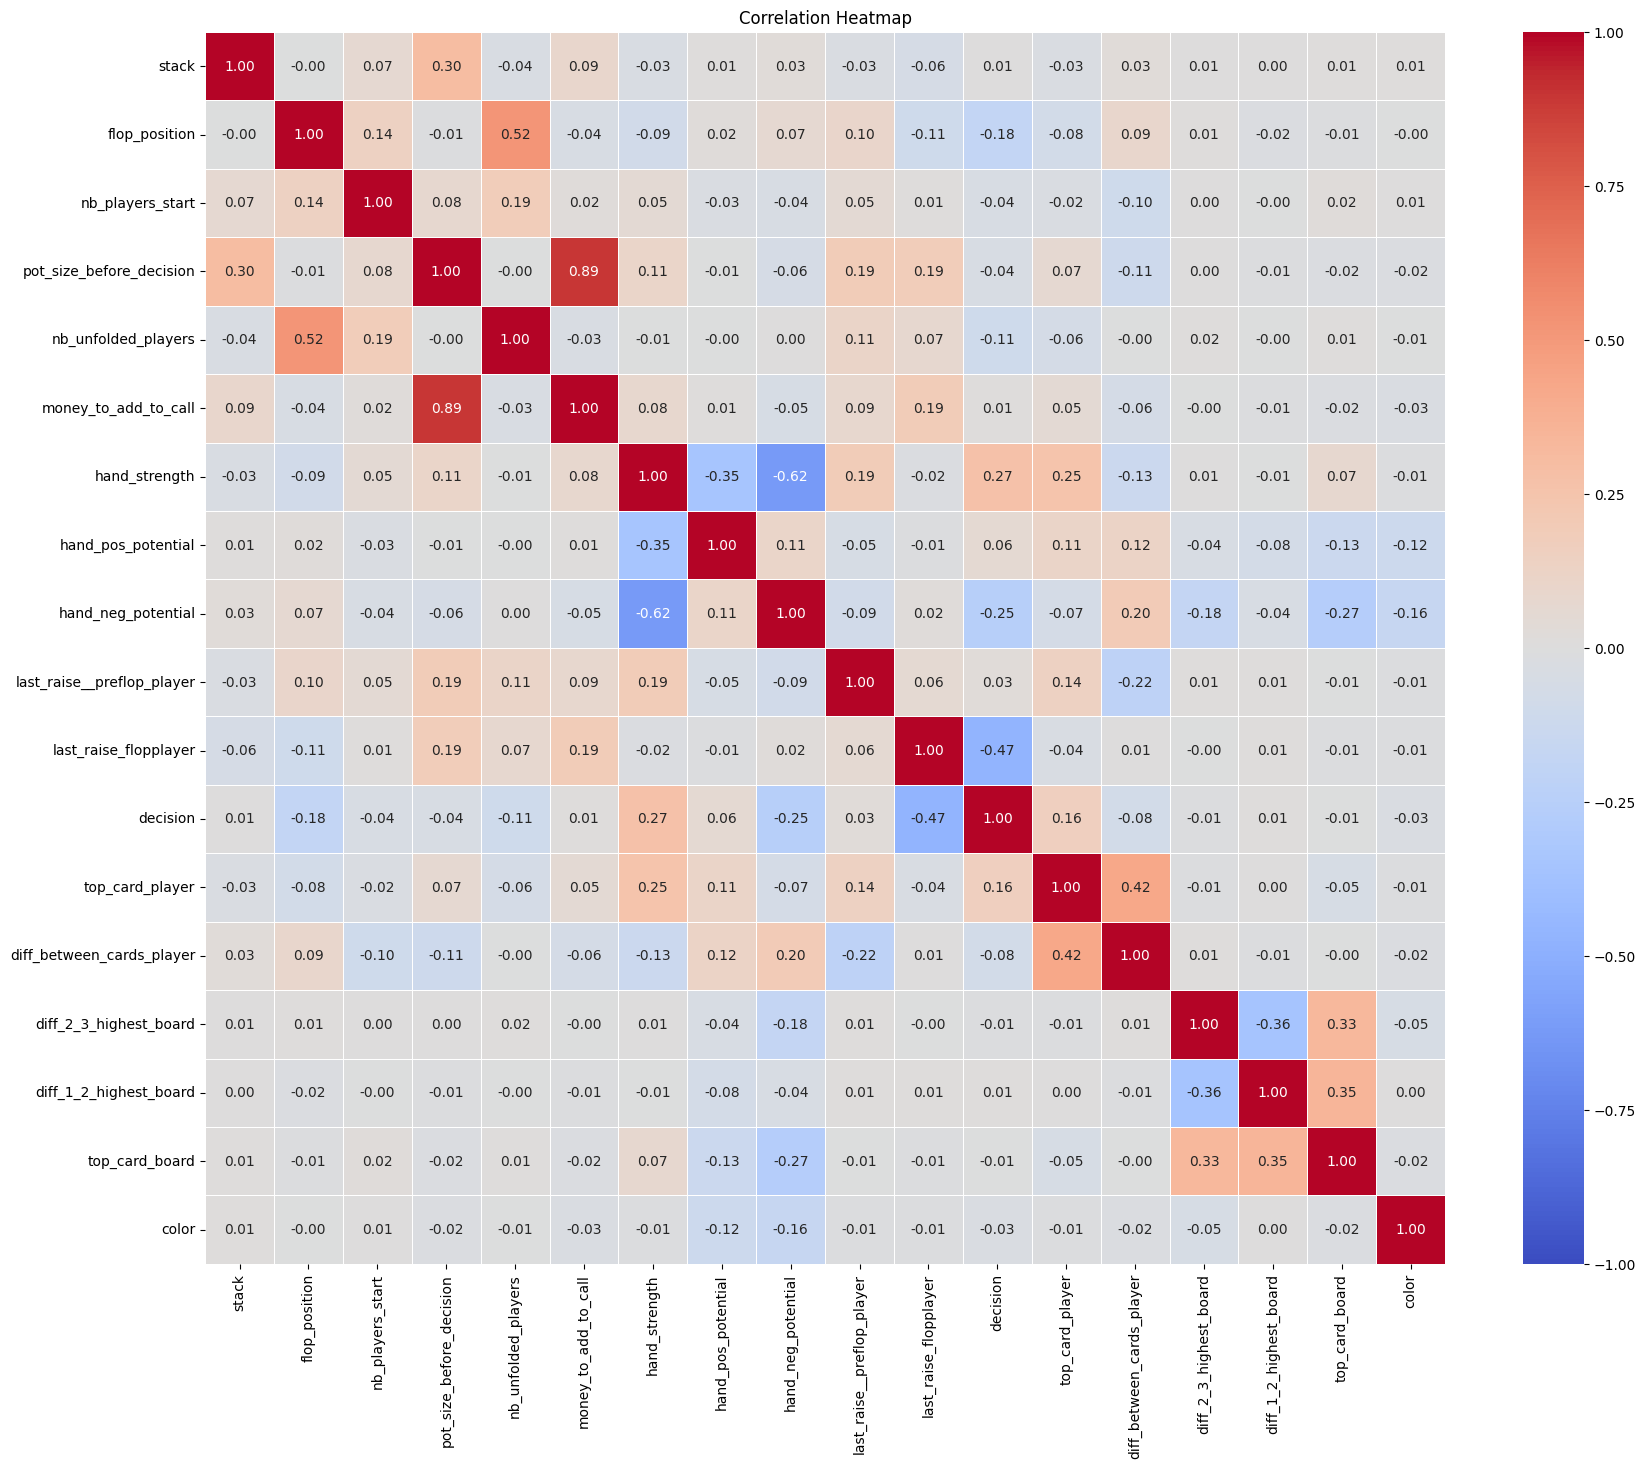

In [ ]:
n= df['decision'].nunique()
features = df.drop(columns=['game_id', 'cards', 'flop', 'mise en cas de raise/bet'])
M = features.corr()


plt.figure(figsize=(20, 16))
sns.heatmap(M, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
pip install --upgrade tensorflow


In [ ]:
# Training
features = df.drop(columns=['game_id', 'decision', 'cards', 'flop',"mise en cas de raise/bet"]).values.astype(np.float32)
labels = df['decision']
labels = labels.values.astype(np.float32)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state = 42)

model = Sequential(
    [
      tf.keras.Input(shape=(X_train.shape[1],)),
      Dense(units=64,activation='relu',name='layer1'),
      Dropout(0.2),
      Dense(units=64,activation='relu',name='layer2'),
      Dropout(0.2),
      Dense(units=64,activation='relu',name='layer3'),
      Dropout(0.2),
      Dense(units=3,activation='softmax',name='layer4')


    ], name = "flop_model1"
)

features = df.drop(columns=['game_id', 'decision', 'cards', 'flop',"mise en cas de raise/bet"]).values.astype(np.float32)
labels = df['decision']
labels = labels.values.astype(np.float32)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state = 42)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

history = model.fit(   X_train,Y_train,    epochs=1000,validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4288 - loss: 1.6836 - val_accuracy: 0.5633 - val_loss: 0.9268
Epoch 2/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5410 - loss: 0.9864 - val_accuracy: 0.6357 - val_loss: 0.8103
Epoch 3/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5900 - loss: 0.8717 - val_accuracy: 0.7269 - val_loss: 0.6648
Epoch 4/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6495 - loss: 0.7694 - val_accuracy: 0.7588 - val_loss: 0.5606
Epoch 5/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7200 - loss: 0.6363 - val_accuracy: 0.7788 - val_loss: 0.4934
Epoch 6/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7483 - loss: 0.6078 - val_accuracy: 0.7982 - val_loss: 0.4241
Epoch 7/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7703 - loss: 0.5100 - val_accuracy: 0.8136 - val_loss: 0.4047
Epoch 8/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7964 - loss: 0.4678 - 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


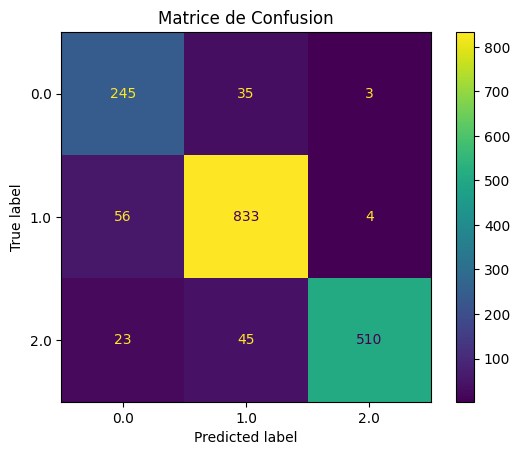

0.8870787446284213


In [ ]:



y_true = Y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title('Matrice de Confusion')
plt.show()

f1 = f1_score(y_true, y_pred, average='macro') # 'binary' pour classification binaire, 'macro' pour multi-classes
print(f1)

In [ ]:
a = max(history.history['accuracy'])
b = max(history.history['val_accuracy'])
print(a)
print(b)

0.9287072420120239
0.9070695638656616


In [ ]:
model.save(r'modele_flop.h5')




In [ ]:
from tensorflow.keras.models import load_model
mod=model.load_model('modele_flop.keras')
mod.summary()

AttributeError: 'Sequential' object has no attribute 'load_model'